## Modelinig approach

### Load the required Python libraries

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import holidays
from sklearn.pipeline import Pipeline
import joblib
import seaborn as sns

### Models for predicting cancellations

#### Model with weather inputs

In [34]:
# Training

sample_data = pd.read_csv("combined.csv")
select_features = ['DATE', 'WEEK', 'MKT_AIRLINE', 'ORIGIN_IATA', 'DEST_IATA', 'SCH_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 
                  'SCH_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'SCH_DURATION', 'DISTANCE', 'CARRIER_DELAY',
                  'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_TYPE','ORIGIN_ELEV',
                  'DEST_TYPE', 'DEST_ELEV', 'origin_temperature_avg_C', 'origin_temperature_min_C', 'origin_temperature_max_C',
                  'origin_precipitation_mm', 'origin_wind_speed_kph', 'origin_snow_mm', 'dest_temperature_avg_C',
                  'dest_temperature_min_C', 'dest_temperature_max_C', 'dest_precipitation_mm', 'dest_wind_speed_kph', 'dest_snow_mm']
df = sample_data[select_features]
df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
us_holidays = holidays.US()
df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
df['DEP_HOUR'] = df['SCH_DEP_TIME'] // 100
df['ARR_HOUR'] = df['SCH_ARR_TIME'] // 100 
excluded = [
    'DATE',                  
    'CANCELLATION_CODE',     
    'DEP_DELAY',             
    'DEP_DELAY_NEW',         
    'ARR_DELAY',             
    'CARRIER_DELAY',         
    'WEATHER_DELAY',         
    'NAS_DELAY',             
    'SECURITY_DELAY',        
    'LATE_AIRCRAFT_DELAY'    
]
X = df.drop(columns=excluded + ['CANCELLED'])
y = df['CANCELLED']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
cat_features_te = ['ORIGIN_IATA', 'DEST_IATA', 'MKT_AIRLINE', 'DEP_HOUR', 'ARR_HOUR']        
cat_features_ohe = ['ORIGIN_TYPE', 'DEST_TYPE', 'WEEK']
num_features = [col for col in X.columns if col not in cat_features_te + cat_features_ohe]
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), cat_features_te),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_ohe)
    ],
    remainder='passthrough'
)

cancelled_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# fit classification model
pipe_cancel_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('classify', XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=cancelled_ratio,
    n_estimators=90,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
    ))
])

pipe_cancel_weather.fit(X_train, y_train)

C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\929764390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\929764390.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\929764390.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['ORIGIN_IATA', 'DEST_IATA',
                                                   'MKT_AIRLINE', 'DEP_HOUR',
                                                   'ARR_HOUR']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ORIGIN_TYPE', 'DEST_TYPE',
                                                   'WEEK'])])),
                ('classify',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsam...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=90, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [35]:
# AUC

y_pred = pipe_cancel_weather.predict(X_test)
y_proba = pipe_cancel_weather.predict_proba(X_test)[:, 1]
print("classification report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

classification report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    492973
           1       0.08      0.77      0.14      8801

    accuracy                           0.83    501774
   macro avg       0.54      0.80      0.52    501774
weighted avg       0.98      0.83      0.89    501774

ROC AUC: 0.8746077150110627


C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\1974914495.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")


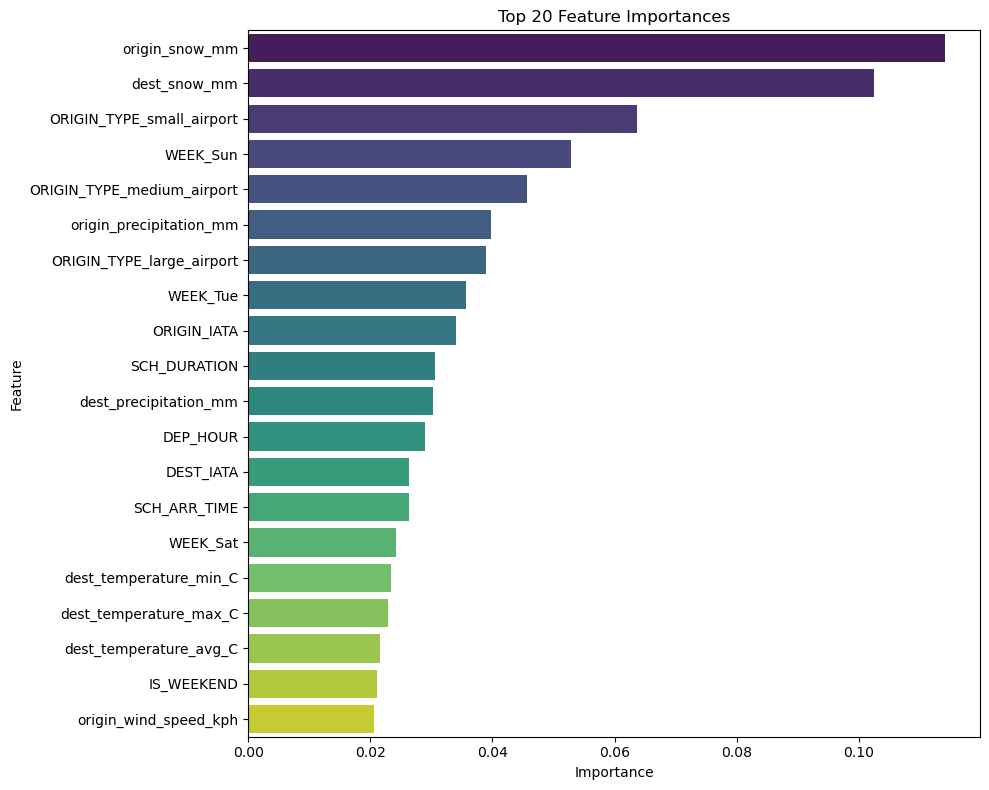

In [36]:
# Feature importance

ohe = preprocessor.named_transformers_['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_features_ohe)  

num_features = [col for col in X.columns if col not in cat_features_ohe]

feature_names = list(ohe_feature_names) + num_features

xgb_cancel = pipe_cancel_weather.named_steps['classify']
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_cancel.feature_importances_
})

top_20 = importance_df.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

#### Model without weather inputs

In [12]:
# Training

# feature engineering
sample_data = pd.read_csv("combined.csv")
select_features = ['DATE', 'WEEK', 'MKT_AIRLINE', 'ORIGIN_IATA', 'DEST_IATA', 'SCH_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 
                  'SCH_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'SCH_DURATION', 'DISTANCE', 'CARRIER_DELAY',
                  'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_TYPE','ORIGIN_ELEV',
                  'DEST_TYPE', 'DEST_ELEV', 'origin_temperature_avg_C', 'origin_temperature_min_C', 'origin_temperature_max_C',
                  'origin_precipitation_mm', 'origin_wind_speed_kph', 'origin_snow_mm', 'dest_temperature_avg_C',
                  'dest_temperature_min_C', 'dest_temperature_max_C', 'dest_precipitation_mm', 'dest_wind_speed_kph', 'dest_snow_mm']
df = sample_data[select_features]
df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
us_holidays = holidays.US()
df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
df['DEP_HOUR'] = df['SCH_DEP_TIME'] // 100
df['ARR_HOUR'] = df['SCH_ARR_TIME'] // 100 
excluded = [
    'DATE',                  
    'CANCELLATION_CODE',     
    'DEP_DELAY',             
    'DEP_DELAY_NEW',         
    'ARR_DELAY',             
    'CARRIER_DELAY',         
    'WEATHER_DELAY',         
    'NAS_DELAY',             
    'SECURITY_DELAY',        
    'LATE_AIRCRAFT_DELAY',
    'origin_temperature_avg_C',
    'origin_temperature_min_C',
    'origin_temperature_max_C',
    'origin_precipitation_mm',
    'origin_wind_speed_kph',
    'origin_snow_mm',
    'dest_temperature_avg_C',
    'dest_temperature_min_C',
    'dest_temperature_max_C',
    'dest_precipitation_mm',
    'dest_wind_speed_kph',
    'dest_snow_mm'
]
X = df.drop(columns=excluded + ['CANCELLED'])
y = df['CANCELLED']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
cat_features_te = ['ORIGIN_IATA', 'DEST_IATA', 'MKT_AIRLINE', 'DEP_HOUR', 'ARR_HOUR']        
cat_features_ohe = ['ORIGIN_TYPE', 'DEST_TYPE', 'WEEK']
num_features = [col for col in X.columns if col not in cat_features_te + cat_features_ohe]
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), cat_features_te),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_ohe)
    ],
    remainder='passthrough'
)

cancelled_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# fit classification model
pipe_cancel_no_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('classify', XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=cancelled_ratio,
    n_estimators=90,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
    ))
])
pipe_cancel_no_weather.fit(X_train, y_train)

C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\962594740.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\962594740.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\962594740.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['ORIGIN_IATA', 'DEST_IATA',
                                                   'MKT_AIRLINE', 'DEP_HOUR',
                                                   'ARR_HOUR']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ORIGIN_TYPE', 'DEST_TYPE',
                                                   'WEEK'])])),
                ('classify',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsam...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=90, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [33]:
# AUC

y_pred = pipe_cancel_no_weather.predict(X_test)
y_proba = pipe_cancel_no_weather.predict_proba(X_test)[:, 1]
print("classification report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

classification report:
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    492973
           1       0.04      0.71      0.07      8801

    accuracy                           0.68    501774
   macro avg       0.52      0.69      0.44    501774
weighted avg       0.98      0.68      0.79    501774

ROC AUC: 0.7646837603526802


C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\918344597.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")


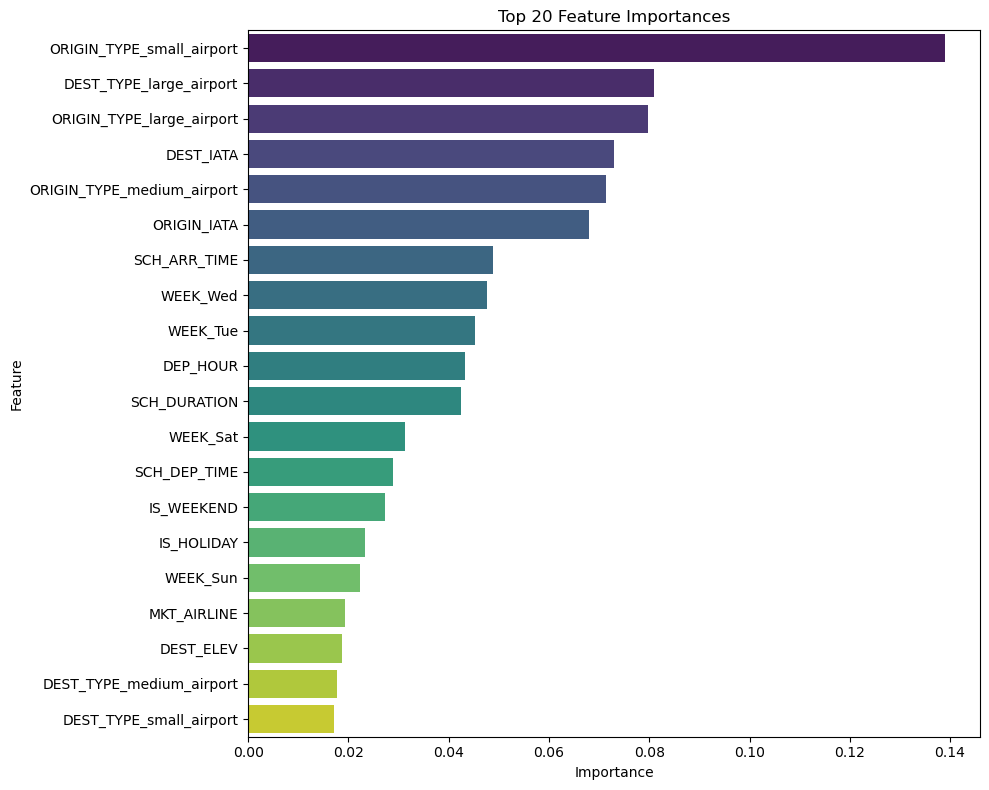

In [14]:
# Feature importance

ohe = preprocessor.named_transformers_['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_features_ohe)  

num_features = [col for col in X.columns if col not in cat_features_ohe]

feature_names = list(ohe_feature_names) + num_features

xgb_cancel = pipe_cancel_no_weather.named_steps['classify']
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_cancel.feature_importances_
})

top_20 = importance_df.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

### Models for predicting delays

#### Models with weather inputs (Departure and arrival)

In [15]:
# Training

sample_data = pd.read_csv("combined.csv")
select_features = ['DATE', 'WEEK', 'MKT_AIRLINE', 'ORIGIN_IATA', 'DEST_IATA', 'SCH_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 
                  'SCH_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'SCH_DURATION', 'DISTANCE', 'CARRIER_DELAY',
                  'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_TYPE','ORIGIN_ELEV',
                  'DEST_TYPE', 'DEST_ELEV', 'origin_temperature_avg_C', 'origin_temperature_min_C', 'origin_temperature_max_C',
                  'origin_precipitation_mm', 'origin_wind_speed_kph', 'origin_snow_mm', 'dest_temperature_avg_C',
                  'dest_temperature_min_C', 'dest_temperature_max_C', 'dest_precipitation_mm', 'dest_wind_speed_kph', 'dest_snow_mm']
df = sample_data[select_features]
df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
us_holidays = holidays.US()
df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
df['DEP_HOUR'] = df['SCH_DEP_TIME'] // 100
df['ARR_HOUR'] = df['SCH_ARR_TIME'] // 100
df = df.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])

def find_outlier_indices(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)].index
dep_delay_outlier_indices = find_outlier_indices(df['DEP_DELAY'])
arr_delay_outlier_indices = find_outlier_indices(df['ARR_DELAY'])
outlier_indices = dep_delay_outlier_indices.union(arr_delay_outlier_indices)
df = df.drop(index=outlier_indices)
excluded_features = [
    'DATE',                  
    'CANCELLED',             
    'CANCELLATION_CODE',     
    'DEP_DELAY_NEW',         
    'CARRIER_DELAY',         
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'ARR_DELAY',
    'DEP_DELAY'              
]

features = df.drop(columns=excluded_features)
target_dep_delay = df['DEP_DELAY']
target_arr_delay = df['ARR_DELAY']
cat_features_te = ['ORIGIN_IATA', 'DEST_IATA', 'MKT_AIRLINE', 'DEP_HOUR', 'ARR_HOUR']          
cat_features_ohe = ['ORIGIN_TYPE', 'DEST_TYPE', 'WEEK'] 
num_features = [col for col in features.columns if col not in cat_features_te + cat_features_ohe]

preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), cat_features_te),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_ohe)
    ],
    remainder='passthrough'
)

X_dep_train, X_dep_test, y_dep_train, y_dep_test = train_test_split(
    features, target_dep_delay, test_size=0.2, random_state=42
)

pipe_dep_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=90,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipe_dep_weather.fit(X_dep_train, y_dep_train)

X_arr_train, X_arr_test, y_arr_train, y_arr_test = train_test_split(
    features, target_arr_delay, test_size=0.2, random_state=42
)

pipe_arr_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=90,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipe_arr_weather.fit(X_arr_train, y_arr_train)

C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\697553962.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\697553962.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\697553962.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['ORIGIN_IATA', 'DEST_IATA',
                                                   'MKT_AIRLINE', 'DEP_HOUR',
                                                   'ARR_HOUR']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ORIGIN_TYPE', 'DEST_TYPE',
                                                   'WEEK'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsam...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=90, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [16]:
# MSE for both

y_dep_pred = pipe_dep_weather.predict(X_dep_test)
y_arr_pred = pipe_arr_weather.predict(X_arr_test)

mse_dep = mean_squared_error(y_dep_test, y_dep_pred)
print(f"MSE for departure delay model: {mse_dep:.2f}")

mse_arr = mean_squared_error(y_arr_test, y_arr_pred)
print(f"MSE for arrival delay model: {mse_arr:.2f}")

MSE for departure delay model: 136.07
MSE for arrival delay model: 219.92


C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\2356653358.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")


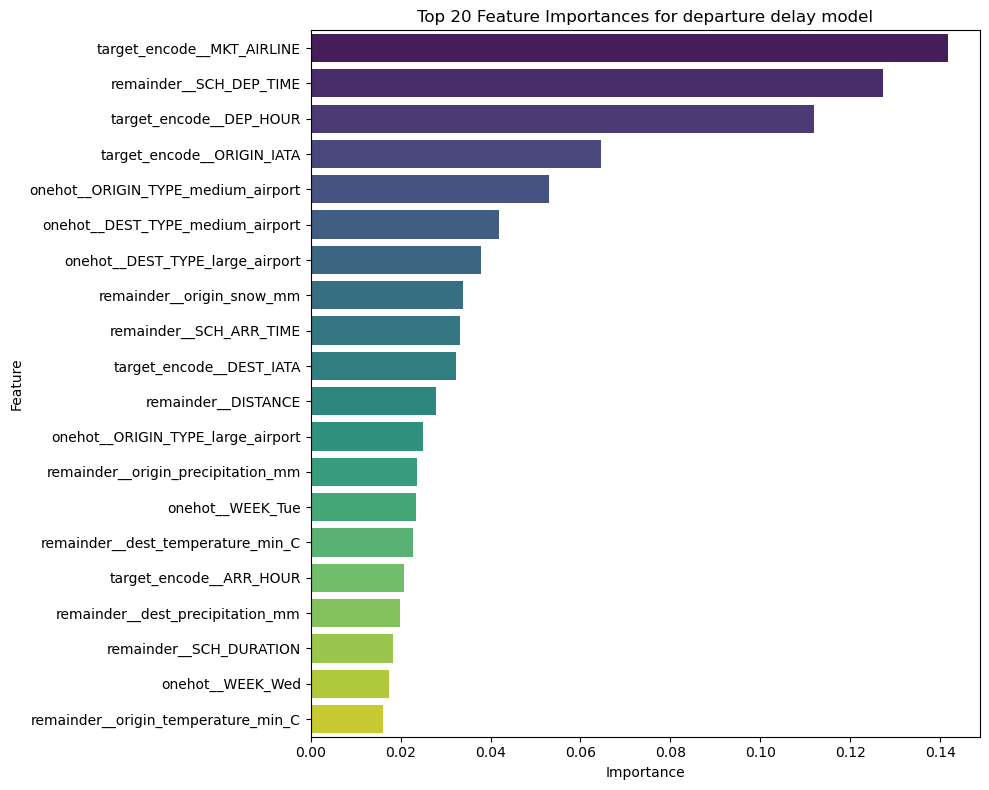

In [31]:
# Feature importance for departure delay model

feature_names_dep = pipe_dep_weather.named_steps['preprocessor'].get_feature_names_out()
xgb_model_dep = pipe_dep_weather.named_steps['regressor']
importances_dep = xgb_model_dep.feature_importances_
feature_importance_dep = pd.DataFrame({
    'feature': feature_names_dep,
    'importance': importances_dep
}).sort_values(by='importance', ascending=False)

top_20 = feature_importance_dep.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances for departure delay model")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\1909205163.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")


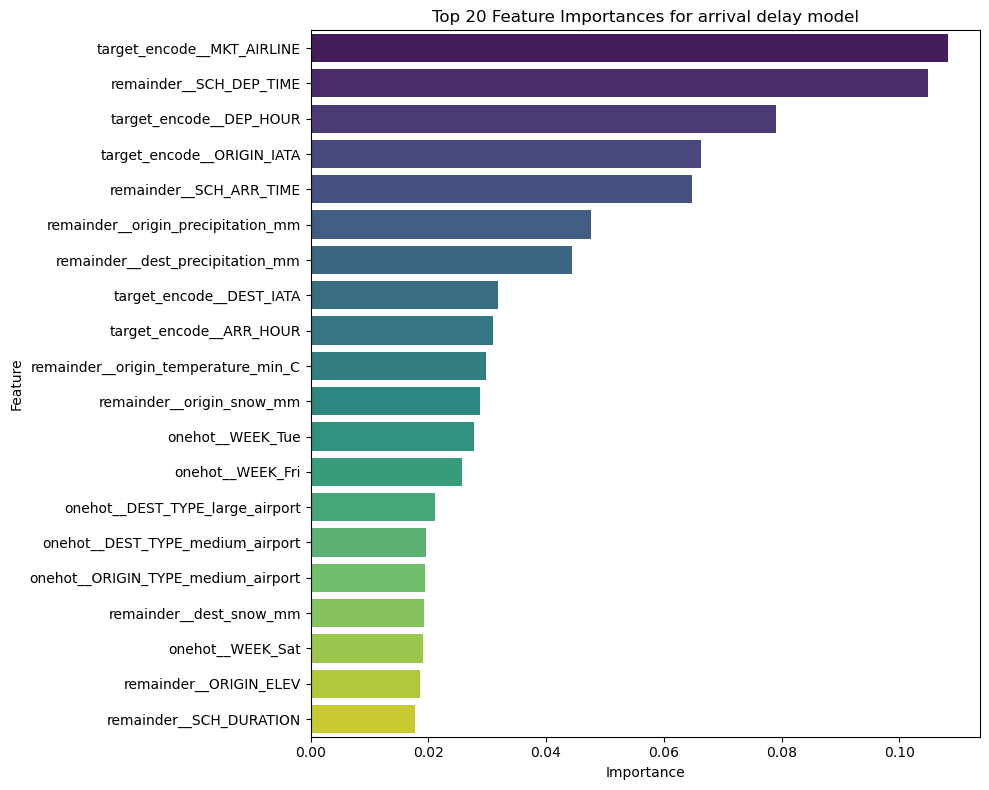

In [30]:
# Feature importance for arrival delay model

feature_names_arr = pipe_arr_weather.named_steps['preprocessor'].get_feature_names_out()
xgb_model_arr = pipe_arr_weather.named_steps['regressor']
importances_arr = xgb_model_arr.feature_importances_
feature_importance_arr = pd.DataFrame({
    'feature': feature_names_arr,
    'importance': importances_arr
}).sort_values(by='importance', ascending=False)

top_20 = feature_importance_arr.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances for arrival delay model")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

#### Models without weather inputs (Departure and arrival)

In [21]:
# Training

sample_data = pd.read_csv("combined.csv")
select_features = ['DATE', 'WEEK', 'MKT_AIRLINE', 'ORIGIN_IATA', 'DEST_IATA', 'SCH_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 
                  'SCH_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'SCH_DURATION', 'DISTANCE', 'CARRIER_DELAY',
                  'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_TYPE','ORIGIN_ELEV',
                  'DEST_TYPE', 'DEST_ELEV', 'origin_temperature_avg_C', 'origin_temperature_min_C', 'origin_temperature_max_C',
                  'origin_precipitation_mm', 'origin_wind_speed_kph', 'origin_snow_mm', 'dest_temperature_avg_C',
                  'dest_temperature_min_C', 'dest_temperature_max_C', 'dest_precipitation_mm', 'dest_wind_speed_kph', 'dest_snow_mm']
df = sample_data[select_features]
df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
us_holidays = holidays.US()
df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
df['DEP_HOUR'] = df['SCH_DEP_TIME'] // 100
df['ARR_HOUR'] = df['SCH_ARR_TIME'] // 100
df = df.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])

def find_outlier_indices(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)].index
dep_delay_outlier_indices = find_outlier_indices(df['DEP_DELAY'])
arr_delay_outlier_indices = find_outlier_indices(df['ARR_DELAY'])
outlier_indices = dep_delay_outlier_indices.union(arr_delay_outlier_indices)
df = df.drop(index=outlier_indices)
excluded_features = [
    'DATE',                  
    'CANCELLED',             
    'CANCELLATION_CODE',     
    'DEP_DELAY_NEW',         
    'CARRIER_DELAY',         
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'ARR_DELAY',
    'DEP_DELAY',
    'origin_temperature_avg_C',
    'origin_temperature_min_C',
    'origin_temperature_max_C',
    'origin_precipitation_mm',
    'origin_wind_speed_kph',
    'origin_snow_mm',
    'dest_temperature_avg_C',
    'dest_temperature_min_C',
    'dest_temperature_max_C',
    'dest_precipitation_mm',
    'dest_wind_speed_kph',
    'dest_snow_mm'
]

features = df.drop(columns=excluded_features)
target_dep_delay = df['DEP_DELAY']
target_arr_delay = df['ARR_DELAY']
cat_features_te = ['ORIGIN_IATA', 'DEST_IATA', 'MKT_AIRLINE', 'DEP_HOUR', 'ARR_HOUR']          
cat_features_ohe = ['ORIGIN_TYPE', 'DEST_TYPE', 'WEEK']  
num_features = [col for col in features.columns if col not in cat_features_te + cat_features_ohe]

preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), cat_features_te),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_ohe)
    ],
    remainder='passthrough'
)

X_dep_train, X_dep_test, y_dep_train, y_dep_test = train_test_split(
    features, target_dep_delay, test_size=0.2, random_state=42
)

pipe_dep_no_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=90,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipe_dep_no_weather.fit(X_dep_train, y_dep_train)

X_arr_train, X_arr_test, y_arr_train, y_arr_test = train_test_split(
    features, target_arr_delay, test_size=0.2, random_state=42
)

pipe_arr_no_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=90,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipe_arr_no_weather.fit(X_arr_train, y_arr_train)

C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\1467013262.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\1467013262.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\1467013262.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['ORIGIN_IATA', 'DEST_IATA',
                                                   'MKT_AIRLINE', 'DEP_HOUR',
                                                   'ARR_HOUR']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ORIGIN_TYPE', 'DEST_TYPE',
                                                   'WEEK'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsam...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=90, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [28]:
# MSE for both

y_dep_pred = pipe_dep_no_weather.predict(X_dep_test)
y_arr_pred = pipe_arr_no_weather.predict(X_arr_test)

mse_dep = mean_squared_error(y_dep_test, y_dep_pred)
print(f"MSE for departure delay model (no weather): {mse_dep:.2f}")

mse_arr = mean_squared_error(y_arr_test, y_arr_pred)
print(f"MSE for arrival delay model (no weather): {mse_arr:.2f}")

MSE for departure delay model (no weather): 136.22
MSE for arrival delay model (no weather): 225.96


C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\3736126796.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")


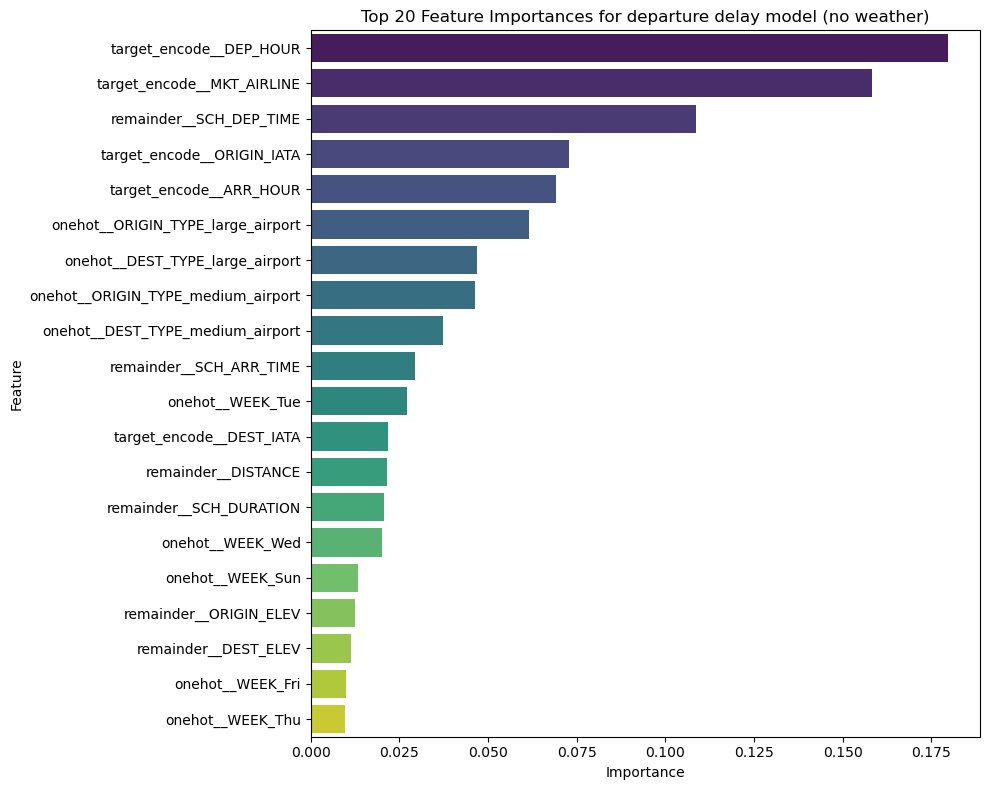

In [26]:
# Feature importance for departure delay model

feature_names_dep = pipe_dep_no_weather.named_steps['preprocessor'].get_feature_names_out()
xgb_model_dep = pipe_dep_no_weather.named_steps['regressor']
importances_dep = xgb_model_dep.feature_importances_
feature_importance_dep = pd.DataFrame({
    'feature': feature_names_dep,
    'importance': importances_dep
}).sort_values(by='importance', ascending=False)

top_20 = feature_importance_dep.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances for departure delay model (no weather)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

C:\Users\Unicorn\AppData\Local\Temp\ipykernel_8048\2267863896.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")


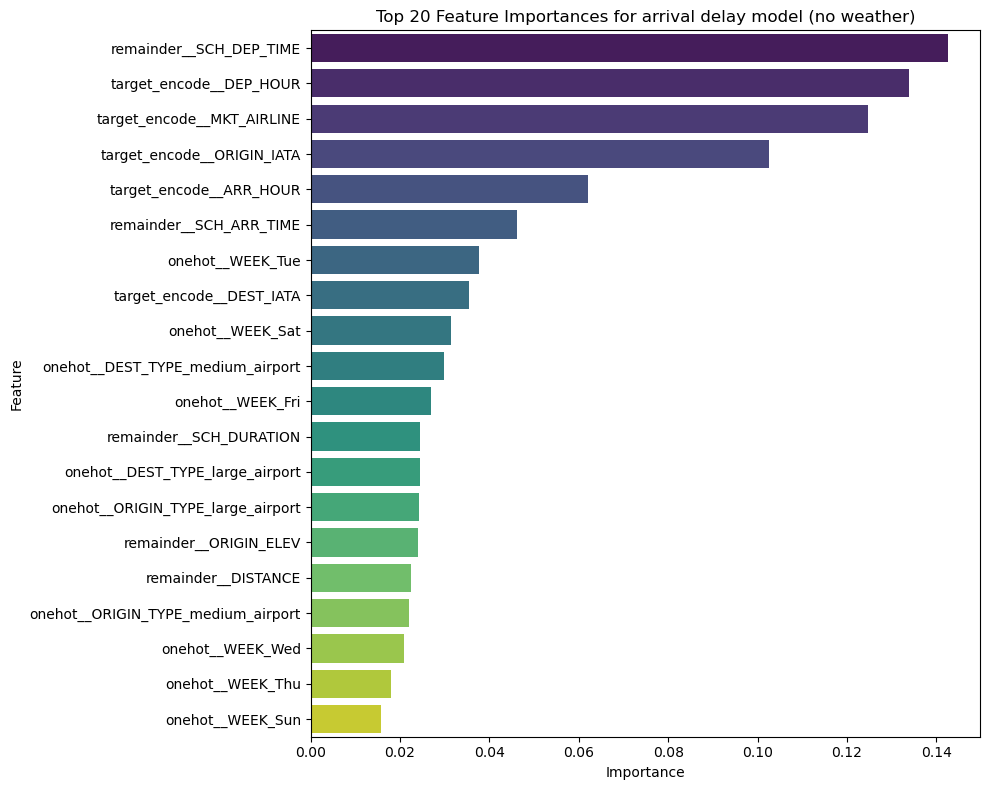

In [27]:
# Feature importance for arrival delay model

feature_names_arr = pipe_arr_no_weather.named_steps['preprocessor'].get_feature_names_out()
xgb_model_arr = pipe_arr_no_weather.named_steps['regressor']
importances_arr = xgb_model_arr.feature_importances_
feature_importance_arr = pd.DataFrame({
    'feature': feature_names_arr,
    'importance': importances_arr
}).sort_values(by='importance', ascending=False)

top_20 = feature_importance_arr.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances for arrival delay model (no weather)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()